# Part I. RUL prediction using Transformer model (Centralize model)

# Preparation

In [1]:
# When run code on Colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
print(f'IN_COLAB: {IN_COLAB}')

IN_COLAB: False


In [2]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib

In [3]:
# Off log duplicate messages
import os
os.environ["RAY_DEDUP_LOGS"] = "0"

# Off warning messages
import warnings
warnings.filterwarnings('ignore')

if not IN_COLAB:
    try:
        import pyinspect as pi
    except:
        pass

In [4]:
from collections import OrderedDict
from typing import List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from datasets.utils.logging import disable_progress_bar

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
# from flwr_datasets import FederatedDataset

import shap

2025-02-11 07:48:48,141	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
/home/os/anaconda3/envs/.venv/lib/python3.12/site-packages/shap/plots/colors/_colorconv.py:819: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if np.issubdtype(dtype_in, np.dtype(dtype).type):


In [5]:
# Check GPU if available else CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cuda
Flower 1.14.0 / PyTorch 2.5.1+cu124


# Building Transformer model

In [6]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dim_feedforward, dropout):
        super(TransformerModel, self).__init__()
        self.input_embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 5000, d_model))
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, src):
        src_emb = self.input_embedding(src) + self.positional_encoding[:, :src.size(1), :]
        src_emb = src_emb.permute(1, 0, 2)
        transformer_out = self.transformer(src_emb, src_emb)
        output = self.fc_out(transformer_out[-1, :, :])
        return output.squeeze(-1)

# Building Dataloader

In [7]:
class CMAPSSLoaderDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length
        self.sequences = []
        self.targets = []

        grouped = data.groupby('ID Engine')
        for _, group in grouped:
            values = group.drop(['ID Engine', 'Cycle', 'Setting 1', 'Setting 2', 'Setting 3','Remaining RUL'], axis=1).values
            rul_values = group['Remaining RUL'].values

            for i in range(len(values) - sequence_length + 1):
                self.sequences.append(values[i:i + sequence_length])
                self.targets.append(rul_values[i + sequence_length - 1])

    def __len__(self):

        return len(self.sequences)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.sequences[idx], dtype=torch.float32),
            torch.tensor(self.targets[idx], dtype=torch.float32),
        )

# Define parameters for training

In [8]:
# Transformer parameters
input_dim = 21
d_model = 64
nhead = 4
num_layers = 2
dim_feedforward = 256
dropout = 0.1
learning_rate = 1e-3
verbose=False

# Dataloader parameters
sequence_length = 30

# Training parameters
batch_size = 128
epochs = 50

# Define training/test functions

In [9]:
def train_model(model, client_loader_train, client_loader_validation: None, epochs: int, learning_rate: int, verbose=False):
    model = model.to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in client_loader_train:
            seq, target = batch
            seq, target = seq.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()
            output = model(seq)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for batch in client_loader_validation:
                seq, target = batch
                seq, target = seq.to(DEVICE), target.to(DEVICE)
                output = model(seq)
                loss = criterion(output, target)
                val_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(client_loader_train)}, Validation Loss: {val_loss/len(client_loader_validation)}")

In [10]:
def test_model(model, client_loader_validation, return_actual_rul=False, show_fig=False):
    criterion = nn.MSELoss()

    samples, targets = next(iter(client_loader_validation))
    samples, targets = samples.to(DEVICE), targets.to(DEVICE)

    model.eval()
    val_loss = 0
    accuracy = 0
    with torch.no_grad():
        for batch in client_loader_validation:
            samples, targets = batch
            samples, targets = samples.to(DEVICE), targets.to(DEVICE)
            predictions = model(samples)
            val_loss += criterion(predictions, targets).item()
    return val_loss/len(client_loader_validation)

# Define prediction functions

### Prediction on a batch

In [11]:
def predict_on_batch(model, batch_loader, return_actual_rul=False, show_fig=False):
    criterion = nn.MSELoss()
    samples, targets = batch_loader
    samples, targets = samples.to(DEVICE), targets.to(DEVICE)

    model.eval()
    loss = 0
    with torch.no_grad():
        predictions = model(samples)
    loss = criterion(predictions, targets)

    if return_actual_rul:
        samples = samples.cpu()
        targets = targets.cpu()

        rul_min = scaler.data_min_[-1]
        rul_max = scaler.data_max_[-1]

        predictions = predictions.cpu()
        actual_predictions = predictions.numpy() * (rul_max - rul_min) + rul_min
        actual_targets = targets.numpy() * (rul_max - rul_min) + rul_min

        if show_fig:
            plt.figure(figsize=(10, 6))
            plt.plot(range(len(actual_predictions)), actual_predictions, label="Predicted RUL", marker='o', linestyle='-')
            plt.plot(range(len(actual_targets)), actual_targets, label="Actual RUL", marker='x', linestyle='--')
            plt.title("Comparison of Predicted and Actual RUL")
            plt.xlabel("Sample Index")
            plt.ylabel("Remaining Useful Life (RUL)")
            plt.legend()
            plt.grid(True)
            plt.show()

        return loss, actual_predictions, actual_targets

    return loss

### Prediction on a sample

# File paths

In [12]:
if not IN_COLAB:
    train_1_path = "../data/train_FD001.txt"
    test_1_path = "../data/test_FD001.txt"
    rul_1_path = "../data/RUL_FD001.txt"

    train_2_path = "../data/train_FD002.txt"
    test_2_path = "../data/test_FD002.txt"
    rul_2_path = "../data/RUL_FD002.txt"

    train_3_path = "../data/train_FD003.txt"
    test_3_path = "../data/test_FD003.txt"
    rul_3_path = "../data/RUL_FD003.txt"

    train_4_path = "../data/train_FD004.txt"
    test_4_path = "../data/test_FD004.txt"
    rul_4_path = "../data/RUL_FD004.txt"
    
elif IN_COLAB:
    train_1_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/train_FD001.txt"
    test_1_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/test_FD001.txt"
    rul_1_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/RUL_FD001.txt"

    train_2_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/train_FD002.txt"
    test_2_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/test_FD002.txt"
    rul_2_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/RUL_FD002.txt"

    train_3_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/train_FD003.txt"
    test_3_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/test_FD003.txt"
    rul_3_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/RUL_FD003.txt"

    train_4_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/train_FD004.txt"
    test_4_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/test_FD004.txt"
    rul_4_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/RUL_FD004.txt"

In [13]:
# Initialization columns
index_names = ['ID Engine', 'Cycle']
setting_names = ['Setting 1', 'Setting 2', 'Setting 3']
sensor_names = ['Sensor {}'.format(i) for i in range(1, 22)]
column_names = index_names + setting_names + sensor_names

# Calculate RUL for FD001

### Calculate RUL for train set

In [14]:
# Load trainset
train_1 = pd.read_csv(train_1_path, sep=' ', header=None)
train_1.drop([26, 27], axis=1, inplace=True)
train_1.columns = column_names

train_1['Remaining RUL'] = ''
# train_1.head()

In [15]:
# Calculate the remaining RUL for each engine
max_cycle_1 = train_1.groupby('ID Engine').count()
for idx in range(len(train_1)):
    train_1.loc[idx, 'Remaining RUL'] = max_cycle_1.loc[train_1.loc[idx, 'ID Engine'], 'Cycle']
train_1['Remaining RUL'] = train_1['Remaining RUL'] - train_1['Cycle']

print(f"trainset shape: {train_1.shape}")

trainset shape: (20631, 27)


In [16]:
train_1.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


### Load RUL set

In [17]:
rul_1 = pd.read_csv(rul_1_path, sep=' ', header=None)
rul_1.drop(rul_1.columns[1], axis=1, inplace=True)
rul_1.columns = ['RUL']
print(f'RUL shape: {rul_1.shape}')

RUL shape: (100, 1)


Tập RUL này là vòng đời còn lại của động cơ sau khi trải qua số lượng chu kỳ nhất định trong tập test (tương ứng)

In [18]:
rul_1.head()

,RUL
0,112
1,98
2,69
3,82
4,91


### Calculate RUL for test

In [19]:
# Load test set
test_1 = pd.read_csv(test_1_path, sep=' ', header=None)
test_1.drop([26, 27], axis=1, inplace=True)
test_1.columns = column_names

test_1['Remaining RUL'] = ''
# test_1.head()

In [20]:
max_cycle_test_1 = test_1.groupby('ID Engine').count()

for idx in range(len(test_1)):
    test_1.loc[idx, 'Remaining RUL'] = rul_1.loc[test_1.loc[idx, 'ID Engine'] - 1, 'RUL'] + max_cycle_test_1.loc[test_1.loc[idx, 'ID Engine'], 'Cycle']
test_1['Remaining RUL'] = test_1['Remaining RUL'] - test_1['Cycle']

In [21]:
test_1.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138


# Calculate RUL for FD002

### Calculate RUL for train set

In [22]:
# Load trainset
train_2 = pd.read_csv(train_2_path, sep=' ', header=None)
train_2.drop([26, 27], axis=1, inplace=True)
train_2.columns = column_names

train_2['Remaining RUL'] = ''
# train_2.head()

In [23]:
# Calculate the remaining RUL for each engine
max_cycle_2 = train_2.groupby('ID Engine').count()
for idx in range(len(train_2)):
    train_2.loc[idx, 'Remaining RUL'] = max_cycle_2.loc[train_2.loc[idx, 'ID Engine'], 'Cycle']
train_2['Remaining RUL'] = train_2['Remaining RUL'] - train_2['Cycle']

print(f"trainset shape: {train_2.shape}")

trainset shape: (53759, 27)


In [24]:
train_2.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,148
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,147
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,146
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701,145
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286,144


### Load RUL set

In [25]:
rul_2 = pd.read_csv(rul_2_path, sep=' ', header=None)
rul_2.drop(rul_2.columns[1], axis=1, inplace=True)
rul_2.columns = ['RUL']
print(f'RUL shape: {rul_2.shape}')

RUL shape: (259, 1)


Tập RUL này là vòng đời còn lại của động cơ sau khi trải qua số lượng chu kỳ nhất định trong tập test (tương ứng)

In [26]:
rul_2.head()

,RUL
0,18
1,79
2,106
3,110
4,15


### Calculate RUL for test

In [27]:
# Load test set
test_2 = pd.read_csv(test_2_path, sep=' ', header=None)
test_2.drop([26, 27], axis=1, inplace=True)
test_2.columns = column_names

test_2['Remaining RUL'] = ''
# test_2.head()

In [28]:
max_cycle_test_2 = test_2.groupby('ID Engine').count()

for idx in range(len(test_2)):
    test_2.loc[idx, 'Remaining RUL'] = rul_2.loc[test_2.loc[idx, 'ID Engine'] - 1, 'RUL'] + max_cycle_test_2.loc[test_2.loc[idx, 'ID Engine'], 'Cycle']
test_2['Remaining RUL'] = test_2['Remaining RUL'] - test_2['Cycle']

In [29]:
test_2.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,9.9987,0.2502,100.0,489.05,605.03,1497.17,1304.99,10.52,...,2388.18,8114.10,8.6476,0.03,369,2319,100.00,28.42,17.1551,275
1,1,2,20.0026,0.7000,100.0,491.19,607.82,1481.20,1246.11,9.35,...,2388.12,8053.06,9.2405,0.02,364,2324,100.00,24.29,14.8039,274
2,1,3,35.0045,0.8400,100.0,449.44,556.00,1359.08,1128.36,5.48,...,2387.75,8053.04,9.3472,0.02,333,2223,100.00,14.98,8.9125,273
3,1,4,42.0066,0.8410,100.0,445.00,550.17,1349.69,1127.89,3.91,...,2387.72,8066.90,9.3961,0.02,332,2212,100.00,10.35,6.4181,272
4,1,5,24.9985,0.6213,60.0,462.54,536.72,1253.18,1050.69,7.05,...,2028.05,7865.66,10.8682,0.02,305,1915,84.93,14.31,8.5740,271


# Calculate RUL for FD003

### Calculate RUL for train set

In [30]:
# Load trainset
train_3 = pd.read_csv(train_3_path, sep=' ', header=None)
train_3.drop([26, 27], axis=1, inplace=True)
train_3.columns = column_names

train_3['Remaining RUL'] = ''
# train_3.head()

In [31]:
# Calculate the remaining RUL for each engine
max_cycle_3 = train_3.groupby('ID Engine').count()
for idx in range(len(train_3)):
    train_3.loc[idx, 'Remaining RUL'] = max_cycle_3.loc[train_3.loc[idx, 'ID Engine'], 'Cycle']
train_3['Remaining RUL'] = train_3['Remaining RUL'] - train_3['Cycle']

print(f"trainset shape: {train_3.shape}")

trainset shape: (24720, 27)


In [32]:
train_3.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,258
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,257
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,256
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,255
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,254


### Load RUL set

In [33]:
rul_3 = pd.read_csv(rul_3_path, sep=' ', header=None)
rul_3.drop(rul_3.columns[1], axis=1, inplace=True)
rul_3.columns = ['RUL']
print(f'RUL shape: {rul_3.shape}')

RUL shape: (100, 1)


Tập RUL này là vòng đời còn lại của động cơ sau khi trải qua số lượng chu kỳ nhất định trong tập test (tương ứng)

In [34]:
rul_3.head()

,RUL
0,44
1,51
2,27
3,120
4,101


### Calculate RUL for test

In [35]:
# Load test set
test_3 = pd.read_csv(test_3_path, sep=' ', header=None)
test_3.drop([26, 27], axis=1, inplace=True)
test_3.columns = column_names

test_3['Remaining RUL'] = ''
# test_3.head()

In [36]:
max_cycle_test_3 = test_3.groupby('ID Engine').count()

for idx in range(len(test_3)):
    test_3.loc[idx, 'Remaining RUL'] = rul_3.loc[test_3.loc[idx, 'ID Engine'] - 1, 'RUL'] + max_cycle_test_3.loc[test_3.loc[idx, 'ID Engine'], 'Cycle']
test_3['Remaining RUL'] = test_3['Remaining RUL'] - test_3['Cycle']

In [37]:
test_3.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0017,-0.0004,100.0,518.67,641.94,1581.93,1396.93,14.62,...,2387.94,8133.48,8.3760,0.03,391,2388,100.0,39.07,23.4468,276
1,1,2,0.0006,-0.0002,100.0,518.67,642.02,1584.86,1398.90,14.62,...,2388.01,8137.44,8.4062,0.03,391,2388,100.0,39.04,23.4807,275
2,1,3,0.0014,-0.0003,100.0,518.67,641.68,1581.78,1391.92,14.62,...,2387.94,8138.25,8.3553,0.03,391,2388,100.0,39.10,23.4244,274
3,1,4,0.0027,0.0001,100.0,518.67,642.20,1584.53,1395.34,14.62,...,2387.96,8137.07,8.3709,0.03,392,2388,100.0,38.97,23.4782,273
4,1,5,-0.0001,0.0001,100.0,518.67,642.46,1589.03,1395.86,14.62,...,2387.97,8134.20,8.4146,0.03,391,2388,100.0,39.09,23.3950,272


# Calculate RUL for FD004

### Calculate RUL for train set

In [38]:
# Load trainset
train_4 = pd.read_csv(train_4_path, sep=' ', header=None)
train_4.drop([26, 27], axis=1, inplace=True)
train_4.columns = column_names

train_4['Remaining RUL'] = ''
# train_4.head()

In [39]:
# Calculate the remaining RUL for each engine
max_cycle_4 = train_4.groupby('ID Engine').count()
for idx in range(len(train_4)):
    train_4.loc[idx, 'Remaining RUL'] = max_cycle_4.loc[train_4.loc[idx, 'ID Engine'], 'Cycle']
train_4['Remaining RUL'] = train_4['Remaining RUL'] - train_4['Cycle']

print(f"trainset shape: {train_4.shape}")

trainset shape: (61249, 27)


In [40]:
train_4.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,320
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,319
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,318
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,317
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,316


### Load RUL set

In [41]:
rul_4 = pd.read_csv(rul_4_path, sep=' ', header=None)
rul_4.drop(rul_4.columns[1], axis=1, inplace=True)
rul_4.columns = ['RUL']
print(f'RUL shape: {rul_4.shape}')

RUL shape: (248, 1)


Tập RUL này là vòng đời còn lại của động cơ sau khi trải qua số lượng chu kỳ nhất định trong tập test (tương ứng)

In [42]:
rul_4.head()

,RUL
0,22
1,39
2,107
3,75
4,149


### Calculate RUL for test

In [43]:
# Load test set
test_4 = pd.read_csv(test_4_path, sep=' ', header=None)
test_4.drop([26, 27], axis=1, inplace=True)
test_4.columns = column_names

test_4['Remaining RUL'] = ''
# test_4.head()

In [44]:
max_cycle_test_4 = test_4.groupby('ID Engine').count()

for idx in range(len(test_4)):
    test_4.loc[idx, 'Remaining RUL'] = rul_4.loc[test_4.loc[idx, 'ID Engine'] - 1, 'RUL'] + max_cycle_test_4.loc[test_4.loc[idx, 'ID Engine'], 'Cycle']
test_4['Remaining RUL'] = test_4['Remaining RUL'] - test_4['Cycle']

In [45]:
test_4.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,20.0072,0.7000,100.0,491.19,606.67,1481.04,1227.81,9.35,...,2387.78,8048.98,9.2229,0.02,362,2324,100.00,24.31,14.7007,251
1,1,2,24.9984,0.6200,60.0,462.54,536.22,1256.17,1031.48,7.05,...,2028.09,7863.46,10.8632,0.02,306,1915,84.93,14.36,8.5748,250
2,1,3,42.0000,0.8420,100.0,445.00,549.23,1340.13,1105.88,3.91,...,2387.95,8071.13,9.3960,0.02,328,2212,100.00,10.39,6.4365,249
3,1,4,42.0035,0.8402,100.0,445.00,549.19,1339.70,1107.26,3.91,...,2387.90,8078.89,9.3594,0.02,328,2212,100.00,10.56,6.2367,248
4,1,5,35.0079,0.8400,100.0,449.44,555.10,1353.04,1117.80,5.48,...,2387.87,8057.83,9.3030,0.02,333,2223,100.00,14.85,8.9326,247


# Plot number of sample for each dataset

In [46]:
len(train_1)

20631

In [47]:
len(train_2)

53759

In [48]:
len(train_3)

24720

In [49]:
len(train_4)

61249

In [50]:
total = len(train_1) + len(train_2) + len(train_3) + len(train_4)
total

160359

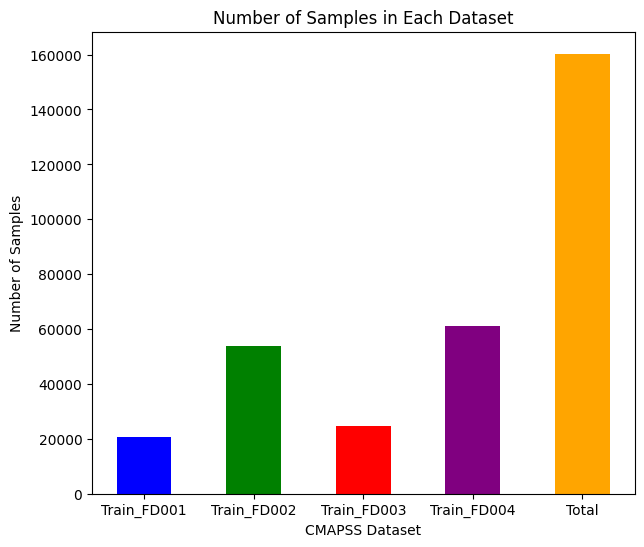

In [51]:
sample_counts = [len(train_1), len(train_2), len(train_3), len(train_4), total]
labels = ['Train_FD001', 'Train_FD002', 'Train_FD003', 'Train_FD004', 'Total']

plt.figure(figsize=(7, 6))
plt.bar(labels, sample_counts, color=['blue', 'green', 'red', 'purple', 'orange'], width=0.5)
plt.xlabel('CMAPSS Dataset')
plt.ylabel('Number of Samples')
plt.title('Number of Samples in Each Dataset')
plt.show()

# Concatenate for train_FD001,2,3,4

In [52]:
print(f'train_1 shape: {train_1.shape}')
print(f'test_1 shape: {test_1.shape}')
print(f'rul_1 shape: {rul_1.shape}')
print(f'max_cycle_1 shape: {max_cycle_1.shape}')

train_1 shape: (20631, 27)
test_1 shape: (13096, 27)
rul_1 shape: (100, 1)
max_cycle_1 shape: (100, 26)


In [53]:
print(f'train_2 shape: {train_2.shape}')
print(f'test_2 shape: {test_2.shape}')
print(f'rul_2 shape: {rul_2.shape}')
print(f'max_cycle_2 shape: {max_cycle_2.shape}')

train_2 shape: (53759, 27)
test_2 shape: (33991, 27)
rul_2 shape: (259, 1)
max_cycle_2 shape: (260, 26)


In [54]:
print(f'train_3 shape: {train_3.shape}')
print(f'test_3 shape: {test_3.shape}')
print(f'rul_3 shape: {rul_3.shape}')
print(f'max_cycle_3 shape: {max_cycle_3.shape}')

train_3 shape: (24720, 27)
test_3 shape: (16596, 27)
rul_3 shape: (100, 1)
max_cycle_3 shape: (100, 26)


In [55]:
print(f'train_4 shape: {train_4.shape}')
print(f'test_4 shape: {test_4.shape}')
print(f'rul_4 shape: {rul_4.shape}')
print(f'max_cycle_4 shape: {max_cycle_4.shape}')

train_4 shape: (61249, 27)
test_4 shape: (41214, 27)
rul_4 shape: (248, 1)
max_cycle_4 shape: (249, 26)


In [56]:
train_1.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [57]:
num = len(train_1)
for idx in range(len(train_2)):
    train_2.loc[idx, 'ID Engine'] += num
train_2.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,20632,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,148
1,20632,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,147
2,20632,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,146
3,20632,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701,145
4,20632,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286,144


In [58]:
num += len(train_2)
for idx in range(len(train_3)):
    train_3.loc[idx, 'ID Engine'] += num
train_3.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,74391,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,258
1,74391,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,257
2,74391,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,256
3,74391,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,255
4,74391,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,254


In [59]:
num += len(train_3)
for idx in range(len(train_4)):
    train_4.loc[idx, 'ID Engine'] += num
train_4.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,99111,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,320
1,99111,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,319
2,99111,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,318
3,99111,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,317
4,99111,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,316


In [ ]:
train = pd.concat([train_1, train_2, train_3, train_4], ignore_index=True)
print(f'Train shape: {train.shape}')
train.head()

Train shape: (160359, 27)


,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


# Standard data (for train and test set)

In [61]:
scaled_columns = train.columns[5:]
scaler = MinMaxScaler()
train[scaled_columns] = scaler.fit_transform(train[scaled_columns])
# test[scaled_columns] = scaler.fit_transform(test[scaled_columns])

In [62]:
train.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0007,-0.0004,100.0,1.0,0.969990,0.927293,0.902111,1.0,...,0.993194,0.653748,0.090428,1.0,0.918367,1.0,1.0,0.972082,0.970373,0.352399
1,1,2,0.0019,-0.0003,100.0,1.0,0.973000,0.932957,0.908192,1.0,...,0.993332,0.637831,0.094654,1.0,0.918367,1.0,1.0,0.970064,0.970630,0.350554
2,1,3,-0.0043,0.0003,100.0,1.0,0.974824,0.922723,0.910730,1.0,...,0.993222,0.641715,0.089844,1.0,0.897959,1.0,1.0,0.968382,0.966204,0.348708
3,1,4,0.0007,0.0000,100.0,1.0,0.974824,0.908829,0.905152,1.0,...,0.993359,0.643055,0.072803,1.0,0.918367,1.0,1.0,0.966028,0.967860,0.346863
4,1,5,-0.0019,-0.0002,100.0,1.0,0.975007,0.908989,0.915565,1.0,...,0.993249,0.642988,0.093829,1.0,0.928571,1.0,1.0,0.966700,0.969560,0.345018


In [63]:
# test.head()

# Training with sequence_length = 1

### Load data into DataLoader

In [64]:
data_train = CMAPSSLoaderDataset(data=train, sequence_length=1)
# data_test = CMAPSSLoaderDataset(data=test, sequence_length=sequence_length)

data_train, data_validation = train_test_split(data_train, test_size=0.2, random_state=42)
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(data_validation, batch_size=batch_size, shuffle=True)

In [65]:
data_train[1][0]

tensor([[0.0000, 0.1262, 0.2916, 0.2269, 0.0000, 0.0025, 0.0077, 0.6272, 0.2661,
         0.2308, 0.4580, 0.0050, 0.9932, 0.5372, 0.4003, 0.0000, 0.2857, 0.6279,
         1.0000, 0.0195, 0.0202]])

In [66]:
data_train[1][1]

tensor(0.4613)

### Training centralize model

In [67]:
centralize_transformer_model = TransformerModel(
    input_dim=input_dim,
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    dim_feedforward=256,
    dropout=dropout
)

In [68]:
try:
    train_model(
        model=centralize_transformer_model,
        client_loader_train=train_loader,
        client_loader_validation=validation_loader,
        epochs=50,
        # epochs=epochs,
        learning_rate=learning_rate,
        verbose=False
    )
except KeyboardInterrupt:
    print("Training interrupted")

Epoch 1/50, Train Loss: 0.03140624475889168, Validation Loss: 0.02281499590977017
Epoch 2/50, Train Loss: 0.014949339308245766, Validation Loss: 0.01203847369661488
Epoch 3/50, Train Loss: 0.011954839690472348, Validation Loss: 0.011545018710388962
Epoch 4/50, Train Loss: 0.011642226372248422, Validation Loss: 0.010993603754239491
Epoch 5/50, Train Loss: 0.011399049030993865, Validation Loss: 0.01079275643089378
Epoch 6/50, Train Loss: 0.011367044803906504, Validation Loss: 0.011119829722683862
Epoch 7/50, Train Loss: 0.011218161371388915, Validation Loss: 0.010594739532283697
Epoch 8/50, Train Loss: 0.011052873738644903, Validation Loss: 0.010190141387283802
Epoch 9/50, Train Loss: 0.010963784228984344, Validation Loss: 0.010799391269387002
Epoch 10/50, Train Loss: 0.010904499694541587, Validation Loss: 0.010430788727054201
Epoch 11/50, Train Loss: 0.01078246711871233, Validation Loss: 0.010300682419799714
Epoch 12/50, Train Loss: 0.010806734928098003, Validation Loss: 0.0102524133566

### Predict on batch

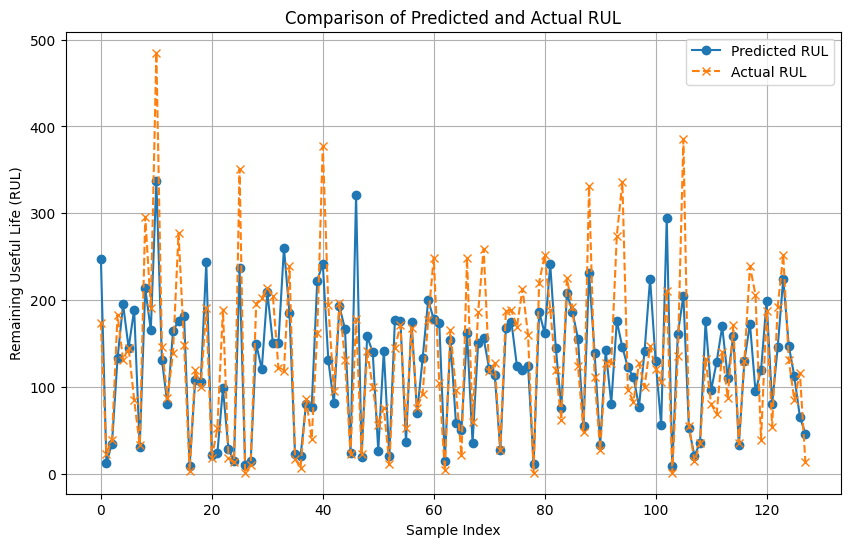

Loss on random batch: 0.010570227168500423


In [69]:
batch_loader = next(iter(validation_loader))

loss, _, _ = predict_on_batch(
    model=centralize_transformer_model,
    batch_loader=batch_loader,
    return_actual_rul=True,
    show_fig=True,
)
print(f'Loss on random batch: {loss}')

# Part II. Explainable Artificial Intelligence for RUL forecasting using Transformer model

### Prediction

In [70]:
# Hàm dự đoán
def predict_single_sample(data_numpy):
    """Dự đoán đầu ra của mô hình cho một mẫu đầu vào."""
    # Đảm bảo dữ liệu có kích thước (batch_size, sequence_length, feature_dim)
    data_tensor = torch.tensor(data_numpy, dtype=torch.float32).to(DEVICE)
    data_tensor = data_tensor.view(data_tensor.shape[0], sequence_length, input_dim)  # Trả về 3D
    centralize_transformer_model.eval()
    with torch.no_grad():
        # Truyền qua mô hình
        predictions = centralize_transformer_model(data_tensor)
    return predictions.cpu().numpy()  # Đầu ra hồi quy (batch_size, 1)

### XAI using SHAP

In [71]:
# Dữ liệu nền và dữ liệu cần giải thích
background_data, _ = next(iter(validation_loader))
background_data_np = background_data.cpu().numpy()  # (batch_size, 1, feature_dim)

# Chuyển đổi dữ liệu nền thành 2D
sequence_length = 1  # Chiều dài chuỗi
feature_dim = background_data_np.shape[-1]  # 21
background_data_2d = background_data_np.reshape(background_data_np.shape[0], -1)  # (batch_size, sequence_length * feature_dim)

# Tóm tắt dữ liệu nền bằng shap.sample
background_sample = shap.sample(background_data_2d, 50)  # Giới hạn 50 mẫu nền để tăng tốc

# Dữ liệu cần giải thích (chuyển đổi 2D tương tự)
data_to_explain = background_data_np[:10]  # Lấy 10 mẫu đầu tiên
data_to_explain_2d = data_to_explain.reshape(data_to_explain.shape[0], -1)  # (10, sequence_length * feature_dim)

In [72]:
# Tạo KernelExplainer
explainer = shap.KernelExplainer(predict_single_sample, background_sample)

# Tính giá trị SHAP
print("Calculating SHAP values...")
shap_values = explainer.shap_values(data_to_explain_2d, nsamples=100)

# Chuyển SHAP values về dạng (num_samples, sequence_length, feature_dim)
shap_values_array = np.array(shap_values).reshape(data_to_explain.shape[0], sequence_length, feature_dim)

# Kiểm tra kích thước
print("Shape of shap_values_array:", shap_values_array.shape)  # (10, 1, 21)
print("Shape of data_to_explain:", data_to_explain.shape)  # (10, 1, 21)

Calculating SHAP values...


  0%|          | 0/10 [00:00<?, ?it/s]/home/os/anaconda3/envs/.venv/lib/python3.12/site-packages/shap/explainers/_kernel.py:640: DeprecationWarning: l1_reg='auto' is deprecated and in a future version the behavior will change from a conditional use of AIC to simply a fixed number of top features. Pass l1_reg='num_features(10)' to opt-in to the new default behaviour.
  warnings.warn(
/home/os/anaconda3/envs/.venv/lib/python3.12/site-packages/shap/explainers/_kernel.py:640: DeprecationWarning: l1_reg='auto' is deprecated and in a future version the behavior will change from a conditional use of AIC to simply a fixed number of top features. Pass l1_reg='num_features(10)' to opt-in to the new default behaviour.
  warnings.warn(
/home/os/anaconda3/envs/.venv/lib/python3.12/site-packages/shap/explainers/_kernel.py:640: DeprecationWarning: l1_reg='auto' is deprecated and in a future version the behavior will change from a conditional use of AIC to simply a fixed number of top features. Pass l

Shape of shap_values_array: (10, 1, 21)
Shape of data_to_explain: (10, 1, 21)


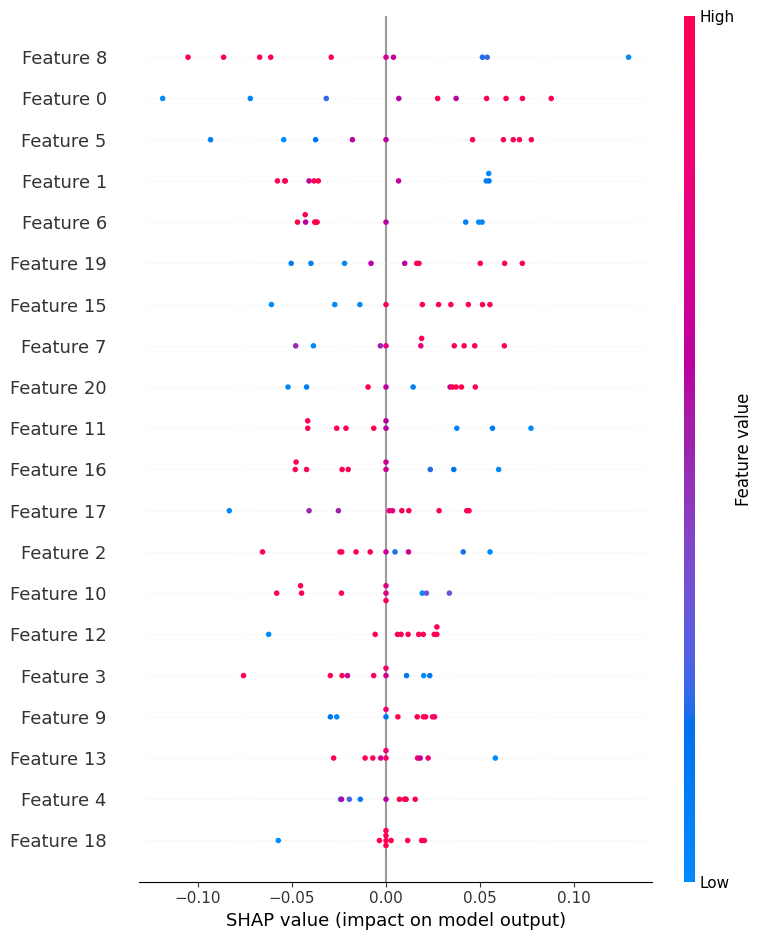

In [73]:
# Vẽ biểu đồ summary (dùng 2D)
data_to_explain_2d = data_to_explain.reshape(data_to_explain.shape[0], -1)
shap_values_2d = shap_values_array.reshape(data_to_explain_2d.shape)
shap.summary_plot(shap_values_2d, data_to_explain_2d)

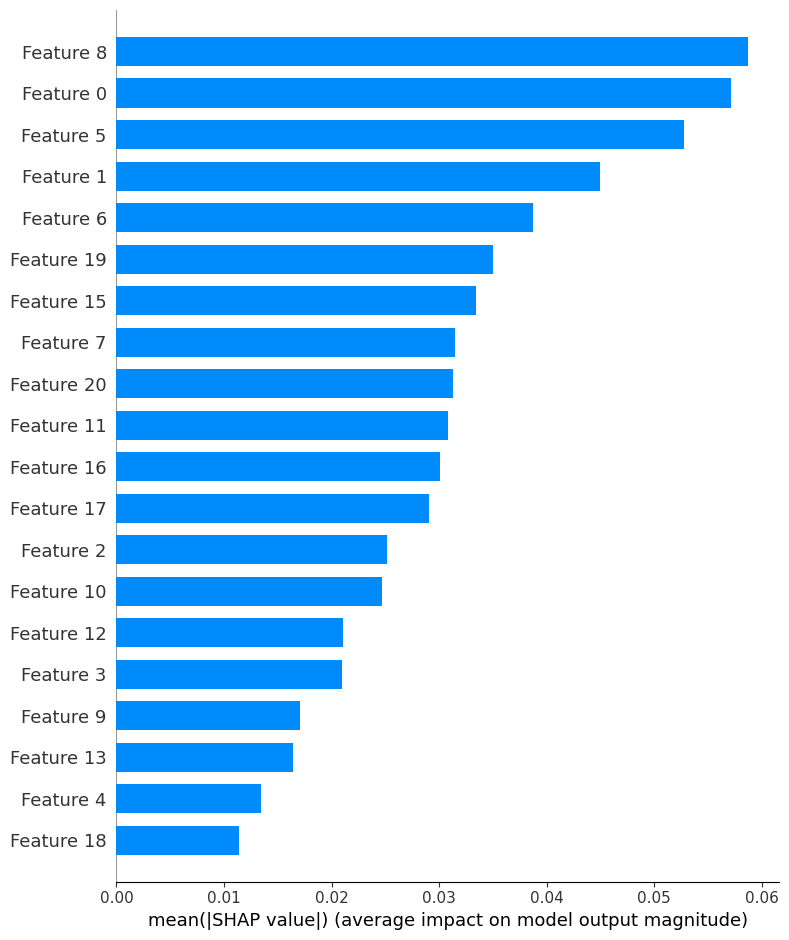

In [74]:
# Vẽ biểu đồ Feature Importance dạng bar chart
shap.summary_plot(shap_values, data_to_explain_2d, plot_type="bar")

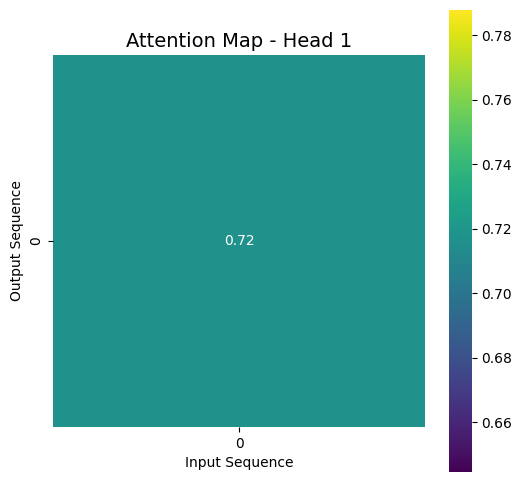

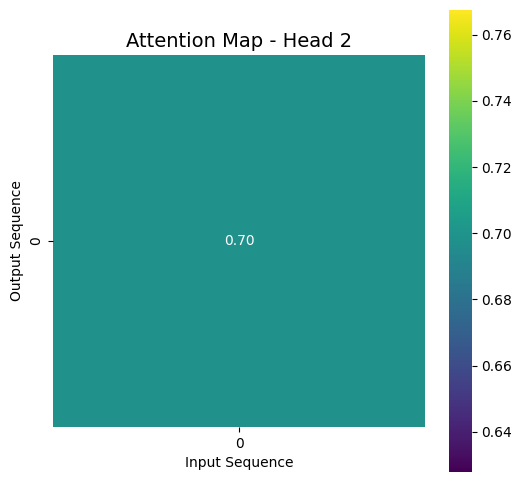

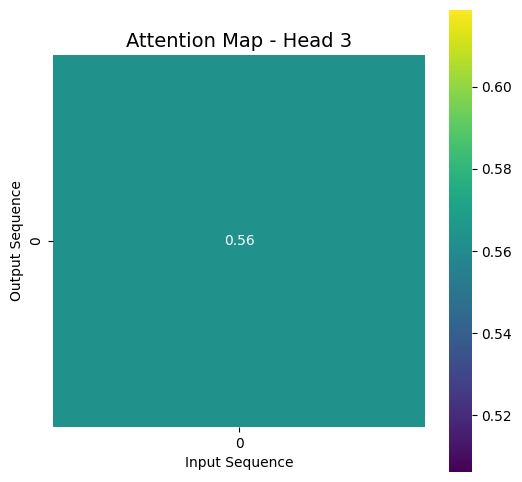

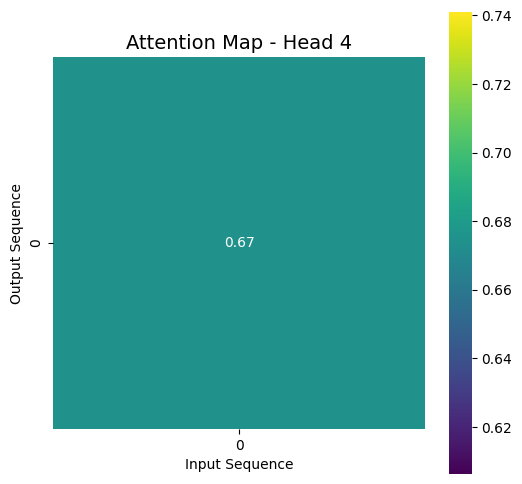

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Giả sử bạn có các trọng số attention từ mô hình Transformer
# attention_weights: tensor có kích thước (num_heads, seq_len, seq_len)

# Một ví dụ nhỏ với trọng số attention
attention_weights = np.random.rand(4, 1, 1)  # num_heads=4, seq_len=1

# Vẽ attention map
def plot_attention_map(attention_weights, head=0):
    """
    Plot attention map for a given head.
    Args:
        attention_weights: numpy array of shape (num_heads, seq_len, seq_len)
        head: Which attention head to visualize (default=0)
    """
    plt.figure(figsize=(6, 6))
    sns.heatmap(
        attention_weights[head],
        annot=True,
        fmt=".2f",
        cmap="viridis",
        cbar=True,
        square=True,
    )
    plt.title(f"Attention Map - Head {head+1}", fontsize=14)
    plt.xlabel("Input Sequence")
    plt.ylabel("Output Sequence")
    plt.show()

# Vẽ attention map cho từng head
for h in range(attention_weights.shape[0]):
    plot_attention_map(attention_weights, head=h)


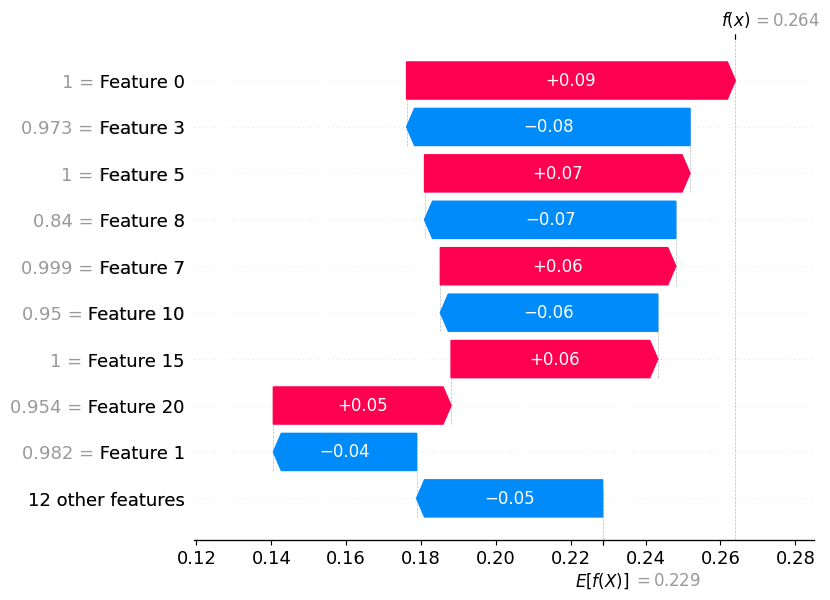

In [76]:
import shap

# Chọn mẫu cần vẽ
sample_idx = 1  # Chỉ số mẫu (thay đổi tùy ý)

# Lấy SHAP values và dữ liệu mẫu
shap_value = shap_values_array[sample_idx]  # Giá trị SHAP cho mẫu (21,)
sample_data = data_to_explain_2d[sample_idx]  # Dữ liệu mẫu (21,)

# Đảm bảo shap_value là 1D
shap_value = shap_value.flatten()

# Vẽ biểu đồ waterfall
shap.waterfall_plot(
    shap.Explanation(
        values=shap_value, 
        base_values=explainer.expected_value, 
        data=sample_data
    )
)


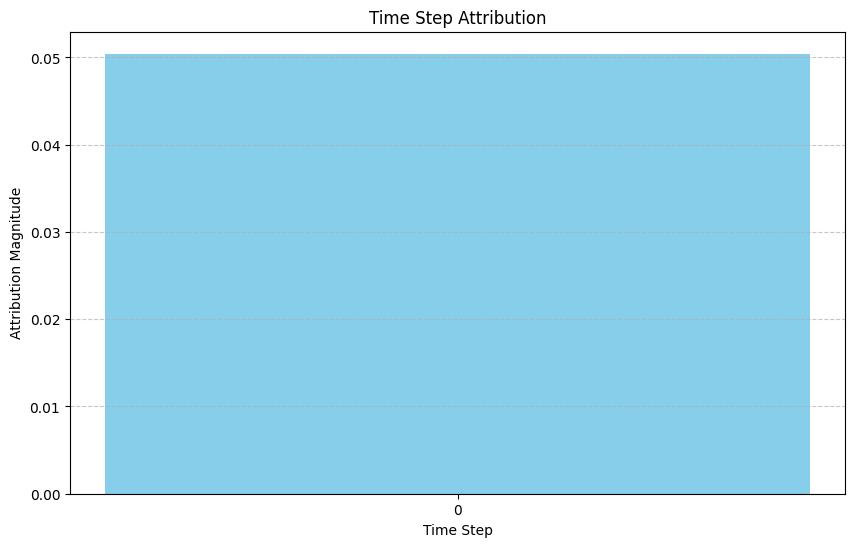

In [77]:
import matplotlib.pyplot as plt
import numpy as np

# Chọn mẫu cần vẽ
sample_idx = 0  # Chỉ số mẫu (thay đổi tùy ý)

# Lấy dữ liệu và SHAP values của mẫu
sample_data = data_to_explain[sample_idx]  # Dữ liệu mẫu (1, sequence_length, num_features)
sequence_length = sequence_length
num_features = feature_dim
sample_shap_values = shap_values_array[sample_idx].reshape(sequence_length, num_features)  # (sequence_length, num_features)

# Tính tổng ảnh hưởng của các đặc trưng tại mỗi time step
time_step_importance = np.abs(sample_shap_values).sum(axis=1)  # Tổng ảnh hưởng mỗi bước thời gian (sequence_length,)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.bar(range(sequence_length), time_step_importance, color="skyblue")
plt.xlabel("Time Step")
plt.ylabel("Attribution Magnitude")
plt.title("Time Step Attribution")
plt.xticks(range(sequence_length))
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


# Part III. Setup Federated Learning with Flower for RUL prediction using Transformer model

### Define parameters for training FL with Flower

In [78]:
num_clients = 10
num_rounds = 50

### Split dataframe to 10 subframe for 10 client

In [79]:
def split_dataset(dataset, num_clients):
    """
    Chia dataset thành num_clients tập con đều nhau.
    Args:
        dataset: Dataset cần chia (torch.utils.data.Dataset).
        num_clients: Số lượng tập con muốn tạo.
    Returns:
        List chứa các tập con của dataset.
    """
    # Kích thước mỗi tập con
    subset_size = len(dataset) // num_clients
    sizes = [subset_size] * num_clients

    # Chia phần dư (nếu tổng dataset không chia hết)
    sizes[-1] += len(dataset) - sum(sizes)

    # Tạo danh sách các tập con
    subsets = random_split(dataset, sizes)
    return subsets

In [80]:
# train.head()
train.shape

(160359, 27)

In [81]:
data = CMAPSSLoaderDataset(train, sequence_length=sequence_length)
train_data, validation_data = train_test_split(data, test_size=0.2, random_state=42)

subset_trains = split_dataset(train_data, num_clients=num_clients)
subset_validations = split_dataset(validation_data, num_clients=num_clients)

client_loader_trains = [DataLoader(subset, batch_size=batch_size, shuffle=True) for subset in subset_trains]
client_loader_validations = [DataLoader(subset, batch_size=batch_size, shuffle=True) for subset in subset_validations]

In [82]:
for i, loader in enumerate(client_loader_trains):
    print(f"Client {i+1} will use a subset with {len(loader.dataset)} samples")

Client 1 will use a subset with 12828 samples
Client 2 will use a subset with 12828 samples
Client 3 will use a subset with 12828 samples
Client 4 will use a subset with 12828 samples
Client 5 will use a subset with 12828 samples
Client 6 will use a subset with 12828 samples
Client 7 will use a subset with 12828 samples
Client 8 will use a subset with 12828 samples
Client 9 will use a subset with 12828 samples
Client 10 will use a subset with 12835 samples


In [83]:
for i, loader in enumerate(client_loader_trains):
    print(f"Client {i+1} will use a subset with {len(loader.dataset)} samples")

Client 1 will use a subset with 12828 samples
Client 2 will use a subset with 12828 samples
Client 3 will use a subset with 12828 samples
Client 4 will use a subset with 12828 samples
Client 5 will use a subset with 12828 samples
Client 6 will use a subset with 12828 samples
Client 7 will use a subset with 12828 samples
Client 8 will use a subset with 12828 samples
Client 9 will use a subset with 12828 samples
Client 10 will use a subset with 12835 samples


### Update model parameters

In [84]:
def set_parameters(model, parameters: List[np.ndarray]):
    params_dict = zip(model.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    model.load_state_dict(state_dict, strict=True)

def get_parameters(model) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in model.state_dict().items()]

### Define the Flower ClientApp

In [85]:
class FlowerClient(NumPyClient):
    def __init__(self, model, client_loader_train, client_loader_validation):
        self.model = model
        self.trainloader = client_loader_train
        self.valloader = client_loader_validation

    def get_parameters(self, config):
        return get_parameters(self.model)

    def fit(self, parameters, config):
        set_parameters(self.model, parameters)
        train_model(
            model=self.model,
            client_loader_train=self.trainloader,
            client_loader_validation=self.valloader,
            epochs=1,
            learning_rate=learning_rate,
            verbose=False
        )
        return get_parameters(self.model), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.model, parameters)
        # loss, accuracy = test(self.model, self.valloader)
        loss = test_model(
            model=self.model,
            client_loader_validation=self.valloader,
            return_actual_rul=False,
            show_fig=False
        )
        return float(loss), len(self.valloader), {"accuracy": float(0.0)}

In [86]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""

    # Load model
    model = TransformerModel(
        input_dim=input_dim,
        d_model=d_model,
        nhead=nhead,
        num_layers=num_layers,
        dim_feedforward=dim_feedforward,
        dropout=0.1
    ).to(DEVICE)

    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data partition
    # Read the node_config to fetch data partition associated to this node
    partition_id = context.node_config["partition-id"]
    trainloader = client_loader_trains[partition_id]
    valloader = client_loader_validations[partition_id]

    # Create a single Flower client representing a single organization
    # FlowerClient is a subclass of NumPyClient, so we need to call .to_client()
    # to convert it to a subclass of `flwr.client.Client`
    return FlowerClient(model, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

### Define the Flower ServerApp

In [87]:
# Create FedAvg strategy
strategy = FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
)

In [88]:
def server_fn(context: Context) -> ServerAppComponents:
    """Construct components that set the ServerApp behaviour.

    You can use the settings in `context.run_config` to parameterize the
    construction of all elements (e.g the strategy or the number of rounds)
    wrapped in the returned ServerAppComponents object.
    """

    # Configure the server for 5 rounds of training
    config = ServerConfig(num_rounds=50)

    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

### Run the training

In [89]:
# Specify the resources each of your clients need
# By default, each client will be allocated 1x CPU and 0x GPUs
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

# When running on GPU, assign an entire GPU for each client
if DEVICE.type == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}
    # Refer to our Flower framework documentation for more details about Flower simulations
    # and how to set up the `backend_config`

In [90]:
!pip install ray==2.6.3

/home/os/anaconda3/envs/.venv/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=434614) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


ERROR: Could not find a version that satisfies the requirement ray==2.6.3 (from versions: 2.31.0, 2.32.0rc0, 2.32.0, 2.33.0, 2.34.0, 2.35.0, 2.36.0, 2.36.1, 2.37.0, 2.38.0, 2.39.0, 2.40.0, 2.41.0, 2.42.0)
ERROR: No matching distribution found for ray==2.6.3


In [91]:
!pip install -q -U "ray[data,train,tune,serve]"

In [92]:
try:
    # Run simulation
    run_simulation(
        server_app=server,
        client_app=client,
        num_supernodes=num_clients,
        backend_config=backend_config
    )
except KeyboardInterrupt:
    print("Simulation interrupted by user.")

INFO :      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.07775741743643096, Validation Loss: 0.023176943166897848
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.0773568732645547, Validation Loss: 0.02476817835122347
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.08133419221359314, Validation Loss: 0.022912815141563233
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.07694296055648586, Validation Loss: 0.024374930761181392
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.07840904635884384, Validation Loss: 0.023343909818392534
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.07989717188226704, Validation Loss: 0.024836863892582748
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.07781014750056928, Validation Loss: 0.02351511216077667
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.08075804279951176, Validation Loss: 0.022976869287399147
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.07757567889103205, Validation Loss: 0.023898360713456687


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.07552590101293408, Validation Loss: 0.02482594005190409


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.03312946527753726, Validation Loss: 0.023806647039376773
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.028789583058788044, Validation Loss: 0.023934945929795504
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.033340310198393196, Validation Loss: 0.022887197538064077
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.032191384085776785, Validation Loss: 0.023713938963527862
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.02982975937204786, Validation Loss: 0.02374263508961751
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.029624694866119045, Validation Loss: 0.025546808655445393
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.02896006291012953, Validation Loss: 0.02335146202061039
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.03127259624624016, Validation Loss: 0.026475332784824647
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.03324959468612872, Validation Loss: 0.0254022259121904


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.028927678445188124, Validation Loss: 0.027501152685055368


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.02609508274362819, Validation Loss: 0.023453340579110842
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.027286221522210847, Validation Loss: 0.024540394974442627
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.026599216837399076, Validation Loss: 0.02353181030887824
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.02593377085015325, Validation Loss: 0.024366634109845527
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.026923479161935278, Validation Loss: 0.025533601498374574
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.025859711968367644, Validation Loss: 0.0243584829597519
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.02573082361849818, Validation Loss: 0.023811581472937878
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.02504962369209469, Validation Loss: 0.023710659346901454
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.02660280401532603, Validation Loss: 0.024333126699695222


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.025751925949560533, Validation Loss: 0.025315110714962848


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.025405843050615624, Validation Loss: 0.02406009702155223
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.025252591320636248, Validation Loss: 0.02349676901044754
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.02557364486084126, Validation Loss: 0.02317445553266085
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.02508913074610847, Validation Loss: 0.02441251091659069
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.026135145898650188, Validation Loss: 0.02347116838567532
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.025217596386181245, Validation Loss: 0.02354290121449874
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.025201732200561183, Validation Loss: 0.024934480110040076
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.02454350269076848, Validation Loss: 0.024663862915566333
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.024907051723929916, Validation Loss: 0.02363266537968929


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.024548988568015618, Validation Loss: 0.0247050324598184


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.023273896536614637, Validation Loss: 0.02318788656535057
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.02377952974621612, Validation Loss: 0.020788594363973692
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.02476958401206106, Validation Loss: 0.02302531568476787
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.024658945960794935, Validation Loss: 0.02200783373644719
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.02493707115512968, Validation Loss: 0.023337799625901077
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.02405213956527486, Validation Loss: 0.02030438557267189
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.02294587015663043, Validation Loss: 0.020738635212183
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.022909348553950243, Validation Loss: 0.01886604239161198
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.024292238084322744, Validation Loss: 0.020926542830868408


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.022871123792806473, Validation Loss: 0.022959645909185592


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.017747291068703232, Validation Loss: 0.013747921464248346
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.020570184934035975, Validation Loss: 0.013949009876411695
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01833968695326902, Validation Loss: 0.01346250118401188
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.017729928993647642, Validation Loss: 0.015078280658389513
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.018260327610417758, Validation Loss: 0.014531083906499239
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.017565832288917338, Validation Loss: 0.012946815373232732
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.018504942573680735, Validation Loss: 0.013942094949575571
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.017766485922038555, Validation Loss: 0.014547504233912779
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.017127724410504988, Validation Loss: 0.014245730466567554


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01690701781633762, Validation Loss: 0.015825364738702774


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.015155656493757622, Validation Loss: 0.012544742642113796
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.015321603469034233, Validation Loss: 0.014203268819703506
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.015159031256369434, Validation Loss: 0.013931259190520415
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01540026999087912, Validation Loss: 0.012810610521298189
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.015068880955476573, Validation Loss: 0.013168323194034971
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.014041676739286078, Validation Loss: 0.01308076735585928
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01462518670918918, Validation Loss: 0.011963803750964312
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01450639332432558, Validation Loss: 0.012430321604300004
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01608698556918909, Validation Loss: 0.012596767574835282


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.014513163449298037, Validation Loss: 0.01294212333428172


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.013266144864408686, Validation Loss: 0.011025001079990314
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.015966751492849672, Validation Loss: 0.012284810493628565
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.014266967210955548, Validation Loss: 0.012187615001144318
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.013829193101034011, Validation Loss: 0.011853880177323636
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.013555609505844883, Validation Loss: 0.014535134944778223
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.013285036447762263, Validation Loss: 0.011648843029084114
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.013149301161860475, Validation Loss: 0.011209456715732813
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012889712444958415, Validation Loss: 0.012675629319766393
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01372606061989128, Validation Loss: 0.010561951292821994


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.013822305431165317, Validation Loss: 0.012020141889269535


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012957049635155956, Validation Loss: 0.010948595089408068
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.013232654578393638, Validation Loss: 0.011321264390762035
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.013384241449397684, Validation Loss: 0.01051574802169433
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012806649015534043, Validation Loss: 0.015629400893186148
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.013039844931278488, Validation Loss: 0.013336433276820641
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012535269344502156, Validation Loss: 0.011892428012708059
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012983682611496142, Validation Loss: 0.01093240324049615
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012727242442640927, Validation Loss: 0.011049065129974714
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012395306333604425, Validation Loss: 0.011479302882575072


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012176743782319055, Validation Loss: 0.011571344668762041


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01285127227627995, Validation Loss: 0.011606761523020955
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012626251072097238, Validation Loss: 0.012495537610867849
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01326083581857752, Validation Loss: 0.0119592034472869
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01258891776646718, Validation Loss: 0.011094474985909004
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012696769549557478, Validation Loss: 0.010510257785566725
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012620480961655037, Validation Loss: 0.011394873798753206
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012332345737089025, Validation Loss: 0.010073339799419045
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012040427964328243, Validation Loss: 0.012172974789371857
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012532978807345475, Validation Loss: 0.013300012976217728


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01199381397391605, Validation Loss: 0.01159436977468431


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01280990928540578, Validation Loss: 0.010795560092307054
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012291264913902424, Validation Loss: 0.011780330409797339
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01275270020976515, Validation Loss: 0.0110732801258564
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012796555659595397, Validation Loss: 0.011272871436981054
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012113296712684159, Validation Loss: 0.012677554542628618
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.013028904440637567, Validation Loss: 0.011389648147787038
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012682772361406006, Validation Loss: 0.011105321634274263
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012039145842047022, Validation Loss: 0.011270875093312217
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012160393114358481, Validation Loss: 0.0107613976400059


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011938751121927606, Validation Loss: 0.011066538030998064


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011885568688595943, Validation Loss: 0.011404349504468532
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012215031412347118, Validation Loss: 0.010823338328359218
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012888738203166735, Validation Loss: 0.011287009988266688
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012190442725942276, Validation Loss: 0.012133421662908334
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012446084447057531, Validation Loss: 0.011718603316694498
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01186069388790886, Validation Loss: 0.011589248306476153
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012036743301824472, Validation Loss: 0.012162987751742968
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011781689471168684, Validation Loss: 0.012028431054204702
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012344547510515936, Validation Loss: 0.013070014771074057


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011538146072906433, Validation Loss: 0.012510977076509824


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012247316898907176, Validation Loss: 0.012431360172251096
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012234979290699605, Validation Loss: 0.011707941285119606
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012574284600259939, Validation Loss: 0.010393875239130396
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01184697060080448, Validation Loss: 0.012558832442244658
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012599951993342084, Validation Loss: 0.011084235344941799
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011944146402696572, Validation Loss: 0.011518020290308274
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.0119612757024346, Validation Loss: 0.012200755962672142
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011715750564996264, Validation Loss: 0.010822409011710148
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012037121866009023, Validation Loss: 0.012784659647597717


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012101630145444138, Validation Loss: 0.014408295508474112


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012324045596662725, Validation Loss: 0.010890126264152618
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012123215417977017, Validation Loss: 0.01305695243466359
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01228113699298684, Validation Loss: 0.011056181115026657
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012053928697610846, Validation Loss: 0.011002488577595124
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012161537456224756, Validation Loss: 0.013326302743875064
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011929154617361503, Validation Loss: 0.013834277382836891
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011988578106064608, Validation Loss: 0.010576429167905679
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011307819405257111, Validation Loss: 0.011164644840531625
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011820570067825293, Validation Loss: 0.011738577087481435


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011406301253355376, Validation Loss: 0.010879114610501207


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01173110573672422, Validation Loss: 0.010818452681772985
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011911007372828403, Validation Loss: 0.010880809671317156
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.0123370512029027, Validation Loss: 0.010963545789798865
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011752414766072047, Validation Loss: 0.011802698127352275
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012323576532820664, Validation Loss: 0.010527284600986885
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011526693419396583, Validation Loss: 0.01088879809070092
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01191105940701938, Validation Loss: 0.010939774622854132
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011430756207371112, Validation Loss: 0.012736811410062589
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012145041640257776, Validation Loss: 0.011223081212777358


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011474486813871282, Validation Loss: 0.011366916247285329


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011708144748601879, Validation Loss: 0.010774183928823242
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012019558473130559, Validation Loss: 0.011602033717701068
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012181323639458359, Validation Loss: 0.010861184734564561
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011691611762721054, Validation Loss: 0.01147030433639884
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01201966545074293, Validation Loss: 0.011083776274552712
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011537809722531255, Validation Loss: 0.011659105899385534
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011765741466516905, Validation Loss: 0.011638736173223991
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011251130132096828, Validation Loss: 0.011356671806424856
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011777390347849024, Validation Loss: 0.010396164358378602


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011127529831806033, Validation Loss: 0.011058528477755876


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01168624312146613, Validation Loss: 0.014881926803634716
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011733130667137333, Validation Loss: 0.011628026500917397
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012289864758011138, Validation Loss: 0.010394011122676043
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011534654862699237, Validation Loss: 0.011691960040479898
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011958212162930481, Validation Loss: 0.012181528485738315
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011395483010328642, Validation Loss: 0.011252204045796623
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011653383045761597, Validation Loss: 0.010352801979304506
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011231600076402767, Validation Loss: 0.011180361732840538
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011692847383420656, Validation Loss: 0.011059942189604044


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011285958793198709, Validation Loss: 0.010601368822300663


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012092957715734397, Validation Loss: 0.011865387849796277
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012027458937857116, Validation Loss: 0.011833041530245772
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012037779264484006, Validation Loss: 0.011458222933400136
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01135336038757964, Validation Loss: 0.012049377466050478
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012004251596471756, Validation Loss: 0.012517745320040446
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011482056211864594, Validation Loss: 0.011466100668677917
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011900665510519602, Validation Loss: 0.01105906029876608
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011512008804532856, Validation Loss: 0.011931148071128588
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011599718049021051, Validation Loss: 0.010630258573935581


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011118256537667891, Validation Loss: 0.011234128990998635


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01175762185974434, Validation Loss: 0.011540091363713145
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01177432844968568, Validation Loss: 0.011210587663719287
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.012035235504407694, Validation Loss: 0.010354775075729076
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011933264875839842, Validation Loss: 0.01216726300593179
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011969435374519907, Validation Loss: 0.011559213332545299
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011773580247259672, Validation Loss: 0.010907493460063752
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.0114123021058812, Validation Loss: 0.010462867955748852
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011257903936254506, Validation Loss: 0.010075458970207434
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011640953812932614, Validation Loss: 0.011024248893730916


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01133332717794888, Validation Loss: 0.012026547490117641


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011867963828810371, Validation Loss: 0.011398209330554191
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011659184410836142, Validation Loss: 0.01027031416574923
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011889973304944464, Validation Loss: 0.011015425418288661
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011319457982104309, Validation Loss: 0.011546544694843201
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011536715994819556, Validation Loss: 0.01118852672740244
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011484212670844086, Validation Loss: 0.011047207822020236
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011612441870245602, Validation Loss: 0.011475135590164708
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011272649525083823, Validation Loss: 0.010439653719703738
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011598771175203642, Validation Loss: 0.011872196999879984


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010997695663925444, Validation Loss: 0.01189539054981791


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01162038797899933, Validation Loss: 0.01076532882423355
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011833437132916532, Validation Loss: 0.010788636156716026
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011570204704040937, Validation Loss: 0.010910899557459813
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011435294754360573, Validation Loss: 0.011271216154385071
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01209853316592698, Validation Loss: 0.010863906059127588
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01136419028135957, Validation Loss: 0.010427427818425573
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.0113666285345755, Validation Loss: 0.011040124003417216
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011106213633118584, Validation Loss: 0.011537087794679862
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01147836992646208, Validation Loss: 0.01143823298983849


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011159417537585049, Validation Loss: 0.011272817223261181


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011416410068326657, Validation Loss: 0.010539623998248806
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011655531966560844, Validation Loss: 0.011236722330347849
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011758201363690124, Validation Loss: 0.010804541444835754
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011325530509584316, Validation Loss: 0.011231669869560462
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011695483750156542, Validation Loss: 0.010471444917269625
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011199146458454946, Validation Loss: 0.011187297220413502
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011366951869487172, Validation Loss: 0.010687419517825428
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01113795486306495, Validation Loss: 0.010321514394420844
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011366486987375682, Validation Loss: 0.010981308439603219


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011404931466878937, Validation Loss: 0.013691520246748742


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011327107861121693, Validation Loss: 0.011094891394560154
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011667316807157333, Validation Loss: 0.010984859017368693
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01164024779665293, Validation Loss: 0.011118658872034688
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011494614105524109, Validation Loss: 0.011688634574126739
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011780170050661752, Validation Loss: 0.010602929969676413
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01124401488295286, Validation Loss: 0.012237318934729466
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011499515241288607, Validation Loss: 0.01042095895928259
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011124369891194424, Validation Loss: 0.01047476141068798
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011288501331490456, Validation Loss: 0.010405239541656695


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010750946136984494, Validation Loss: 0.011104000087540884


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011569009369958451, Validation Loss: 0.01069864034294509
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011424580252369736, Validation Loss: 0.010588178787237177
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01144936212827221, Validation Loss: 0.01057614448766869
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011701272901995937, Validation Loss: 0.012183699004638653
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011684349147916431, Validation Loss: 0.010821950801003438
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011357865983269887, Validation Loss: 0.010845747436038576
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011275566869996267, Validation Loss: 0.01036566488731366
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010906302047395471, Validation Loss: 0.01030184247960838
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011435866793894236, Validation Loss: 0.011344801616640044


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010893715213578526, Validation Loss: 0.011414592297604451


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011374805537559608, Validation Loss: 0.011962861897280583
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011500866239945782, Validation Loss: 0.018495778374087352
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01137770613710774, Validation Loss: 0.010669562285049604
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011443322178640284, Validation Loss: 0.011851349451507513
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011676129608387403, Validation Loss: 0.013124816800252749
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011269755269594417, Validation Loss: 0.011234741389321594
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01143703760929627, Validation Loss: 0.009757425582322937
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01111421145793825, Validation Loss: 0.011559874249192385
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01132326971481342, Validation Loss: 0.010464122895008096


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010771925842371022, Validation Loss: 0.011073286895855116


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011436755787396785, Validation Loss: 0.011193590632711466
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011662686981334545, Validation Loss: 0.010485549761842076
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011760015746043755, Validation Loss: 0.011085463472856926
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011094004063322992, Validation Loss: 0.010493367502931505
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011663993211961028, Validation Loss: 0.01258743411073318
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011202509289072586, Validation Loss: 0.010779838238914426
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01152790322586304, Validation Loss: 0.010569380578370048
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011032386646043547, Validation Loss: 0.010856713239963237
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011329514564632779, Validation Loss: 0.010789892725789776


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010874699510744597, Validation Loss: 0.011027514862899598


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011206516857710805, Validation Loss: 0.010508101558885895
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011524755364781853, Validation Loss: 0.010957137789004125
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011705093805005055, Validation Loss: 0.01035512899621748
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011079735071905473, Validation Loss: 0.011065317819324823
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011642522980818654, Validation Loss: 0.011168215459642502
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011159671276881554, Validation Loss: 0.010991661415363733
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011369738903007295, Validation Loss: 0.010245678391164312
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01087732298189018, Validation Loss: 0.01274724741681264
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011332177824460634, Validation Loss: 0.012340891891374038


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010879730510682162, Validation Loss: 0.010963868188600127


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011367336892993143, Validation Loss: 0.010626041813968467
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011325873028818923, Validation Loss: 0.010670310280357417
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011719232780102751, Validation Loss: 0.010747304275775185
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011195053789063845, Validation Loss: 0.011652257150182357
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011519148618462358, Validation Loss: 0.010642514886477819
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010829144655404115, Validation Loss: 0.010700700195649495
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01124191078089989, Validation Loss: 0.010343510872469498
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010940174853410756, Validation Loss: 0.010420045743768033
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011169278570035896, Validation Loss: 0.010681969794229819


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01092299392059593, Validation Loss: 0.012128062814903947


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011538845293297626, Validation Loss: 0.011146286466660408
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011460056689816832, Validation Loss: 0.010700060233760338
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011582707437585191, Validation Loss: 0.012749824243096205
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011664866479021489, Validation Loss: 0.010290494976708522
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011289025772141643, Validation Loss: 0.011440507458666196
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011006634922163321, Validation Loss: 0.011332252779259132
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011313138193091248, Validation Loss: 0.010415797157642933
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010811527499394251, Validation Loss: 0.013198100281162905
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01138104124474201, Validation Loss: 0.010162007851669421


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010887633474303944, Validation Loss: 0.011635388140208446


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01129869189998596, Validation Loss: 0.011533725182884015
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011342272844792592, Validation Loss: 0.011004297761246562
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01157557305944438, Validation Loss: 0.010633394910165897
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011018269833656821, Validation Loss: 0.010988283293465009
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01146765541063972, Validation Loss: 0.010269116484918274
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01120725357075139, Validation Loss: 0.01080055651254952
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011360850291197547, Validation Loss: 0.010174398095561909
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010816970397487725, Validation Loss: 0.011636978534695048
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011365711200281535, Validation Loss: 0.011082797239606198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010805187709998377, Validation Loss: 0.011067301249847962


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011115186949177543, Validation Loss: 0.012030400407428924
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011386202081189593, Validation Loss: 0.010524563992825838
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011801169807146681, Validation Loss: 0.010425027871790987
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011021778628340747, Validation Loss: 0.012397600355773019
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011550133679025245, Validation Loss: 0.01084388903557108
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011026822791278068, Validation Loss: 0.01210817128706437
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011219427810225746, Validation Loss: 0.010554031522658009
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010850377694362461, Validation Loss: 0.010789589419101294
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011272215150702413, Validation Loss: 0.01051892850619669


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010954626430157977, Validation Loss: 0.010817775341610495


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011203592924382721, Validation Loss: 0.011313251739081282
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011224408223671784, Validation Loss: 0.010682752141012596
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011610658267642012, Validation Loss: 0.011153438361361623
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011088034788165058, Validation Loss: 0.011011024077351276
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011449172461202533, Validation Loss: 0.01061958407696623
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011028559689437695, Validation Loss: 0.010706155811651396
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011047957926103384, Validation Loss: 0.010361209565487046
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01103636721093761, Validation Loss: 0.010399407617604503
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011170987763654182, Validation Loss: 0.010577582539274143


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010673152398096748, Validation Loss: 0.010778161195608286


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011397080744920981, Validation Loss: 0.012443316455643911
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011633014509288392, Validation Loss: 0.010693071589160424
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011467304435733816, Validation Loss: 0.010147144409039846
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01115586148980673, Validation Loss: 0.010997131986256976
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011373575371090728, Validation Loss: 0.010916445278920807
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011109299478259418, Validation Loss: 0.011650970062384238
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011210818032706432, Validation Loss: 0.010200564194327364
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010860459828325132, Validation Loss: 0.010216841492085503
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011057390158276746, Validation Loss: 0.010405789845837997


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010633604587194059, Validation Loss: 0.01189373154193163


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011238817973892288, Validation Loss: 0.011607605211723309
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011405338016845802, Validation Loss: 0.012108823284506798
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011648940844553531, Validation Loss: 0.010295867310980191
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01125873925883581, Validation Loss: 0.01060193066055385
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011596273630857468, Validation Loss: 0.01082175262630559
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011180584374261966, Validation Loss: 0.011387894933040325
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011103776799939057, Validation Loss: 0.01017698385896018
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010863729240833828, Validation Loss: 0.012043413061362047
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.0113353362620467, Validation Loss: 0.010446259250434546


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010700611867895811, Validation Loss: 0.01076270815414878


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01118914979408578, Validation Loss: 0.010922851148419656
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01133001334319758, Validation Loss: 0.010363539645018486
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.0114045634976413, Validation Loss: 0.010385490434530836
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010886222027279067, Validation Loss: 0.011569038087215561
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01140071767483755, Validation Loss: 0.012059277317558344
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011084427287119746, Validation Loss: 0.010862658409258494
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011156196682944451, Validation Loss: 0.011090458908046667
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01091848514826581, Validation Loss: 0.010746459167701406
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011037481584503213, Validation Loss: 0.010252627167994013


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010773417558336612, Validation Loss: 0.010374627828311462


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011103876903284304, Validation Loss: 0.010397554052850375
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011367924041160852, Validation Loss: 0.0116833675151261
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011355655604401733, Validation Loss: 0.010359426136486806
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011078943904157323, Validation Loss: 0.011937869999271173
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011592685355629661, Validation Loss: 0.01049574718882258
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01122012224029934, Validation Loss: 0.012336367096465368
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011137431547377664, Validation Loss: 0.010345103577352487
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010616910616212552, Validation Loss: 0.010053372709080577
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011011220768352252, Validation Loss: 0.010439572031967916


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010596470755183756, Validation Loss: 0.011713688046886371


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011190677587274867, Validation Loss: 0.011605312080624012
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011344813810901182, Validation Loss: 0.011144006803918343
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011364539186147476, Validation Loss: 0.010546485499407236
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011027316821019838, Validation Loss: 0.010913138009177951
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011699745426931888, Validation Loss: 0.012218993730269946
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011171571827392177, Validation Loss: 0.010416377174596373
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011013307853020949, Validation Loss: 0.010211435755571494
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010704892761267648, Validation Loss: 0.010138344574862948
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011117921312256614, Validation Loss: 0.010677272024062963


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010948180368557424, Validation Loss: 0.012718617414625792


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011015435745294141, Validation Loss: 0.010544769286822814
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011283414203230993, Validation Loss: 0.010614476274125852
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01141981490528082, Validation Loss: 0.010118506159275197
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01085260031873932, Validation Loss: 0.011432000829909857
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011345335937077455, Validation Loss: 0.012054665193248253
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01088442913450227, Validation Loss: 0.010785367662230363
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011183855686299872, Validation Loss: 0.018448602264890306
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010627218245500974, Validation Loss: 0.010331092259058585
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011577326998040817, Validation Loss: 0.01012076299565916


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010478618245866924, Validation Loss: 0.010908797275848113


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01119417800466613, Validation Loss: 0.012284898593162116
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011226099164289708, Validation Loss: 0.010736275768767182
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011380396409900767, Validation Loss: 0.010440013335587887
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01092198743291273, Validation Loss: 0.012004348521049205
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011232437994699963, Validation Loss: 0.011575754212502103
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011037848774565033, Validation Loss: 0.010716057991465697
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011060687326042368, Validation Loss: 0.009906245144800497
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010910552732720234, Validation Loss: 0.011299354489892721
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01114187060882992, Validation Loss: 0.014118156037651576


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010743160676764379, Validation Loss: 0.010578789210949954


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011121217373500365, Validation Loss: 0.010155274550645398
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011402174899594324, Validation Loss: 0.010550785899305573
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011393819529895145, Validation Loss: 0.009876005172442932
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011031578594615848, Validation Loss: 0.012525768055079075
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011343128117041128, Validation Loss: 0.011121535960298318
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011012207361694315, Validation Loss: 0.010647796595898958
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011210834999375119, Validation Loss: 0.011091614428621072
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010609800641489501, Validation Loss: 0.010015648467322955
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011220165519136013, Validation Loss: 0.010497907696005244


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010617465790508701, Validation Loss: 0.010707282461225986


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011153087923579877, Validation Loss: 0.010563518099773388
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011132333556761836, Validation Loss: 0.01047161234041246
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011468155890481897, Validation Loss: 0.009826706543278236
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011289207338549124, Validation Loss: 0.01258446928113699
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011177160016417798, Validation Loss: 0.010860106728684444
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010979831108067295, Validation Loss: 0.01068746903911233
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010889276562461464, Validation Loss: 0.01010397535104018
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010566050869108426, Validation Loss: 0.010886857393555917
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011066796682258644, Validation Loss: 0.011934588591639813


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010553285414998484, Validation Loss: 0.011084804812876077


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01105274368391031, Validation Loss: 0.01164993393019988
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011223156373984742, Validation Loss: 0.011133075226098299
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011191195047617253, Validation Loss: 0.010938057246116491
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011316774869429887, Validation Loss: 0.010586534053660356
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011308756043747216, Validation Loss: 0.011039159600981154
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010914089411755305, Validation Loss: 0.01028035948267923
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011034402258620403, Validation Loss: 0.010386506991031079
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010732063129175417, Validation Loss: 0.010650907213298174
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010878399014472961, Validation Loss: 0.010610843059391929


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01054763447696177, Validation Loss: 0.011518137242931586


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011254384053299333, Validation Loss: 0.01035729505551549
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01137642227205457, Validation Loss: 0.010382995224342896
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011293725350336863, Validation Loss: 0.01082702364342717
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011195337150872934, Validation Loss: 0.010810352682780761
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011194870595147115, Validation Loss: 0.01071716694591137
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010939983978388038, Validation Loss: 0.011181572667108132
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011196184525321616, Validation Loss: 0.010188297064115222
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010680009200615754, Validation Loss: 0.010606882681783576
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010873281673555918, Validation Loss: 0.01223852213185567


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01057326244559176, Validation Loss: 0.012530709384009242


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01119831251902598, Validation Loss: 0.010410667361261753
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011046277285359873, Validation Loss: 0.010543869539665488
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011414577686550593, Validation Loss: 0.010497909110899154
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01084705074732699, Validation Loss: 0.011319529874107013
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011298883554184496, Validation Loss: 0.010443657385901762
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010912114966402549, Validation Loss: 0.012163440517794628
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010884047190815505, Validation Loss: 0.01067722959515567
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010628764508384288, Validation Loss: 0.010443493294028135
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011001875462692857, Validation Loss: 0.009940160133947547


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010529081055912937, Validation Loss: 0.010629209886806516


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010920650883586985, Validation Loss: 0.011969140014396263
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011262132159185291, Validation Loss: 0.010627121055642
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011307562853550852, Validation Loss: 0.010735086559389647
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010875522882889697, Validation Loss: 0.01100620380244576
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01132487449426167, Validation Loss: 0.010929507418320729
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010841301716126428, Validation Loss: 0.010689115509963952
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010976452850690573, Validation Loss: 0.010023697154023327
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010561141641902746, Validation Loss: 0.01174830559354562
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010818474681697565, Validation Loss: 0.010950177693023132


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010666139658983095, Validation Loss: 0.010461410274729133


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011045977782162994, Validation Loss: 0.010610125349977842
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011201324623705136, Validation Loss: 0.011596360422957402
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011306676902983448, Validation Loss: 0.00991559037580513
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010782690677275457, Validation Loss: 0.010535663101249017
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011277482420722447, Validation Loss: 0.010739746163240992
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010940492236156864, Validation Loss: 0.011740957279331408
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010917874878401509, Validation Loss: 0.009895714841639766
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010441839533609033, Validation Loss: 0.009944056554769095
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010930489960799712, Validation Loss: 0.010135702520179061


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010585469184535564, Validation Loss: 0.010597340619334808


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011510678428677049, Validation Loss: 0.0112168848192176
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011087402272600643, Validation Loss: 0.010875224243276395
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011188053111038586, Validation Loss: 0.010130446126612905
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010689555999297317, Validation Loss: 0.010733074526517438
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011238524847027689, Validation Loss: 0.012285098684235262
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010700624154899085, Validation Loss: 0.010938615806830617
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011139136351792528, Validation Loss: 0.01022172887594654
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010685062515411046, Validation Loss: 0.01057062351789612
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011000529226690236, Validation Loss: 0.010704516110798487


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01054361480574059, Validation Loss: 0.011069552793812294


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011113922480530667, Validation Loss: 0.010226276595718585
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011329941257908203, Validation Loss: 0.011602855018841533
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011276442276332344, Validation Loss: 0.010165857688452188
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01088916469771083, Validation Loss: 0.010811497905076696
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011283527598670214, Validation Loss: 0.011247465243706336
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010740413164517076, Validation Loss: 0.011144202274198715
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010987129495801901, Validation Loss: 0.011104250810324
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010518061707146687, Validation Loss: 0.010429435051404513
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01083590558241352, Validation Loss: 0.010044404968189506


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010459347946182041, Validation Loss: 0.011449120795497527


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010818262003583483, Validation Loss: 0.0101852527497193
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011104043812887503, Validation Loss: 0.010742651477742653
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011174946797476841, Validation Loss: 0.010604981512117844
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010849877149973175, Validation Loss: 0.010519552107255619
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011254172753727082, Validation Loss: 0.01031469743555555
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010788465061658386, Validation Loss: 0.011062927651577271
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011029117630038521, Validation Loss: 0.009969824387763556
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010599231324389134, Validation Loss: 0.011096706363157583
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010951613486366401, Validation Loss: 0.010284826069926986


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01039144203140594, Validation Loss: 0.010881780037799707


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011078143999496899, Validation Loss: 0.01057083671912551
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010474242127067086, Validation Loss: 0.010359277930827094
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010996147229492959, Validation Loss: 0.010318160074977921
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.01125341962266824, Validation Loss: 0.01137090023033894
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010890393485637879, Validation Loss: 0.011270981532736467
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.011019129601150457, Validation Loss: 0.010971329174935818
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010719782760422123, Validation Loss: 0.011063184642877717
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010859584343610423, Validation Loss: 0.00986017557219244
(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010934059065536107, Validation Loss: 0.009982289441932853


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=438961) Epoch 1/1, Train Loss: 0.010419564819571996, Validation Loss: 0.01234879821109084


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 round(s) in 14357.19s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.02452451682004791
INFO :      		round 2: 0.024086936907126353
INFO :      		round 3: 0.024038004237585342
INFO :      		round 4: 0.023526427327082135
INFO :      		round 5: 0.02104372481743877
INFO :      		round 6: 0.012823513583638348
INFO :      		round 7: 0.011351079816141954
INFO :      		round 8: 0.010912735072466043
INFO :      		round 9: 0.010653391168811
INFO :      		round 10: 0.010639809086345708
INFO :      		round 11: 0.010835784412204072
INFO :      		round 12: 0.011033066283338345
INFO :      		round 13: 0.010730237323934069
INFO :      		round 14: 0.010786869896289247
INFO :      		round 15: 0.01042399245600861
INFO :      		round 16: 0.010730053785328682
INFO :      		round 17: 0.01047377883671568
INFO :      		round 18: 0.01086709714637926
INFO :      		